In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt

import keras
from keras.layers import LeakyReLU, UpSampling1D, Input, Reshape, Activation, Lambda, AveragePooling1D
from keras.layers import Convolution2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import RMSprop
import random
from PIL import Image
import cv2
from keras.layers.merge import concatenate
import csv;
from keras.layers import merge, Convolution2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model
from hw4_tools import *
# From pypng
import png
#from sklearn.p

FONTSIZE = 18
FIGURE_SIZE = (10,4)
FIGURE_SIZE2 = (10,10)

# Configure parameters
plt.rcParams.update({'font.size': FONTSIZE})

####################################
# 
import re

##################
# Default tick label size
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

from hw4_tools import *

Using TensorFlow backend.


## Reading path from CSV

In [2]:
def Fetch_images(filepath):
    ls = [];
    i_pos=[];
    i_neg=[];
    
    with open(filepath) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            ls.append(row[0]);
    
    for i in range(0, len(ls)):
        ls[i]='/home2/bank0014/project_data/'+ls[i]
    
    for i in range(0,len(ls)):
        if((ls[i].find('positive'))>0):
            i_pos.append(ls[i])
        else:
            i_neg.append(ls[i])

    df_pos= pd.DataFrame({'path':i_pos})
    df_neg= pd.DataFrame({'path':i_neg})
    
    return df_pos, df_neg


In [3]:
val_pos, val_neg=Fetch_images('/home2/bank0014/project_data/MURA-v1.1/valid_image_paths.csv')
tr_pos, tr_neg=Fetch_images('/home2/bank0014/project_data/MURA-v1.1/train_image_paths.csv')

In [31]:
len(val_pos)

1530

## Reading Images:

In [5]:
def read_images(df_pos,df_neg,data_range_pos,data_range_neg):
    img_pos=[];
    img_neg=[];
    for i in range(0,data_range_pos):
        img_pos.append(cv2.imread(df_pos.path[i]))
    
    for j in range(0, data_range_neg):
        img_neg.append(cv2.imread(df_neg.path[j]))
    
    return img_pos, img_neg

In [ ]:
val_im_pos, val_im_neg=read_images(val_pos, val_neg,len(val_pos), len(val_neg))
tr_im_pos, tr_im_neg=read_images(tr_pos, tr_neg,len(tr_pos), len(tr_neg))

# Reshaping Images

In [49]:
def reshape_images(img_pos):
    for i in range(0,len(img_pos)):
        img_pos[i]=cv2.resize(src=img_pos[i],dsize=(224,224))
        print (img_pos[i].shape)
        img_pos[i]=np.array(img_pos[i])
        print (img_pos[i].shape)
        img_pos[i]=img_pos[i]/255.
    return img_pos

In [50]:
val_im_pos=reshape_images(val_im_pos)
val_im_neg=reshape_images(val_im_neg)

tr_im_pos=reshape_images(tr_im_pos)
tr_im_neg=reshape_images(tr_im_neg)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 

list

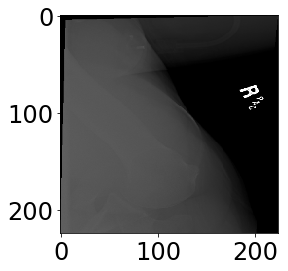

In [8]:
plt.imshow(tr_im_neg[19])
type(tr_im_neg)

In [51]:
val_im_pos=np.array(val_im_pos)
val_im_neg=np.array(val_im_neg)

tr_im_pos=np.array(tr_im_pos)
tr_im_neg=np.array(tr_im_neg)

(224, 224, 3)

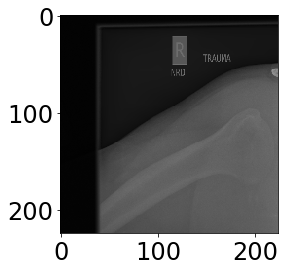

In [9]:
plt.imshow(tr_im_neg[99])
tr_im_neg[99].shape

## Labeling:

In [52]:
val_outs_pos = np.ones(val_im_pos.shape[0])
val_outs_neg = np.zeros(val_im_neg.shape[0])

tr_outs_pos = np.ones(tr_im_pos.shape[0])
tr_outs_neg = np.zeros(tr_im_neg.shape[0])

In [37]:
tr_outs_neg

array([0., 0., 0., ..., 0., 0., 0.])

In [53]:
val_ins = np.append(val_im_pos, val_im_neg, axis=0)
val_outs = np.append(val_outs_pos, val_outs_neg, axis=0)

tr_ins= np.append(tr_im_pos, tr_im_neg, axis=0)
tr_outs = np.append(tr_outs_pos, tr_outs_neg, axis=0)


In [54]:
def construct_model(input_shape, lambda_regularization=0):
    model = Sequential()
    
    # TODO: conv step(s)
    model.add(Convolution2D(filters=30,
                           input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=(3,3),
                            padding='same',
                           use_bias = True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                           kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                   bias_regularizer=keras.regularizers.l2(lambda_regularization),
                           activation='elu',name='c1'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='c11'))
    
    model.add(Convolution2D(filters=20,
                           input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=(2,2),
                            padding='same',
                           use_bias = True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                           kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                   bias_regularizer=keras.regularizers.l2(lambda_regularization),
                           activation='elu',name='c2'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='c22'))
    
    model.add(Convolution2D(filters=10,
                           input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=(2,2),
                            padding='same',
                           use_bias = True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                           kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                   bias_regularizer=keras.regularizers.l2(lambda_regularization),
                           activation='elu',name='c3'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='c33'))
    
    model.add(Convolution2D(filters=10,
                           input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=(1,1),
                            padding='same',
                           use_bias = True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                           kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                   bias_regularizer=keras.regularizers.l2(lambda_regularization),
                           activation='elu',name='c4'))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='c44'))
    model.add(Flatten())
    
    # TODO: dense step(s)
    
        
    model.add(Dense(units = 30,
                    activation = 'elu',
                    use_bias = True,
                    kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                    bias_regularizer=keras.regularizers.l2(lambda_regularization),
                    kernel_initializer = 'random_uniform',
                    bias_initializer = 'random_uniform'))
    
    model.add(Dropout(0.1))

    model.add(Dense(units = 10,
                    activation = 'relu',
                    use_bias = True,
                    kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                    bias_regularizer=keras.regularizers.l2(lambda_regularization),
                    kernel_initializer = 'random_uniform',
                    bias_initializer = 'random_uniform'))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(units = 1,
                    activation = 'sigmoid',
                    use_bias = True,
                    kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                    bias_regularizer=keras.regularizers.l2(lambda_regularization),
                    kernel_initializer = 'random_uniform',
                    bias_initializer = 'random_uniform'))
 


    # The optimizer determines how the gradient descent is to be done
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, 
                                epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [55]:
model = construct_model(tr_ins.shape[1:], 0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c1 (Conv2D)                  (None, 75, 75, 30)        840       
_________________________________________________________________
c11 (MaxPooling2D)           (None, 37, 37, 30)        0         
_________________________________________________________________
c2 (Conv2D)                  (None, 19, 19, 20)        5420      
_________________________________________________________________
c22 (MaxPooling2D)           (None, 9, 9, 20)          0         
_________________________________________________________________
c3 (Conv2D)                  (None, 5, 5, 10)          1810      
_________________________________________________________________
c33 (MaxPooling2D)           (None, 2, 2, 10)          0         
_________________________________________________________________
c4 (Conv2D)                  (None, 2, 2, 10)          910       
__________

In [56]:
model.fit(x=tr_ins, y=tr_outs, epochs=10)

Epoch 1/10
400/400 [==============================] - 10s 25ms/step - loss: 0.7011 - acc: 0.5000
Epoch 2/10
400/400 [==============================] - 5s 12ms/step - loss: 0.7006 - acc: 0.5000
Epoch 3/10
400/400 [==============================] - 5s 12ms/step - loss: 0.7000 - acc: 0.5000
Epoch 4/10
400/400 [==============================] - 4s 11ms/step - loss: 0.6995 - acc: 0.5000
Epoch 5/10
400/400 [==============================] - 4s 11ms/step - loss: 0.6990 - acc: 0.5000
Epoch 6/10
400/400 [==============================] - 5s 12ms/step - loss: 0.6986 - acc: 0.5000
Epoch 7/10
400/400 [==============================] - 5s 12ms/step - loss: 0.6982 - acc: 0.5000
Epoch 8/10
400/400 [==============================] - 5s 11ms/step - loss: 0.6978 - acc: 0.5000
Epoch 9/10
400/400 [==============================] - 5s 12ms/step - loss: 0.6974 - acc: 0.5000
Epoch 10/10
400/400 [==============================] - 5s 12ms/step - loss: 0.6971 - acc: 0.5000


In [42]:
predicted = model.predict(tr_ins[100:275])

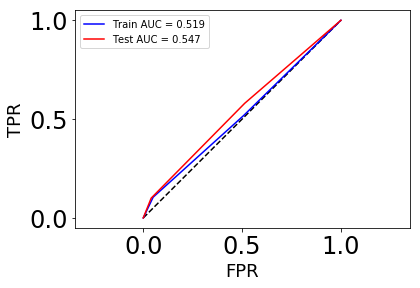

In [57]:
generate_roc(model, tr_ins, tr_outs, tr_ins[150:350], tr_outs[150:350])

# Testing

In [19]:
predict = model.predict(val_ins[175:375])

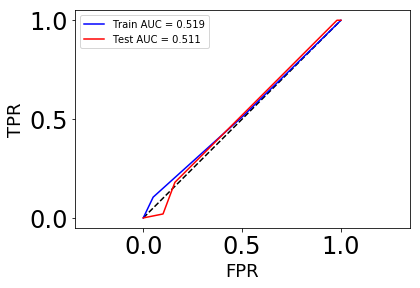

In [58]:
generate_roc(model, tr_ins, tr_outs, val_ins[50:150], val_outs[50:150])